In [ ]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks
#get_ipython().run_line_magic('load_ext', 'autoreload')
#get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

# Parametre des images

In [ ]:
# Taille des images d'entrée
IMAGE_SIZE = 32
# Nombre de canaux de couleur de l'image (1 pour niveaux de gris, 3 pour RVB)
CHANNELS = 1
# Taille du lot (batch) pour l'entraînement du modèle
BATCH_SIZE = 100
# Taille du tampon (buffer) pour le mélange des données
BUFFER_SIZE = 1000
# Proportion des données réservée pour la validation pendant l'entraînement
VALIDATION_SPLIT = 0.2
# Dimension de l'espace latent (représentation compressée des images)
EMBEDDING_DIM = 2
# Nombre d'époques d'entraînement du modèle
EPOCHS = 3

# Étape 1 : Chargement de l'ensemble de données Fashion MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Définition de la fonction preprocess qui prend une variable imgs en entrée
def preprocess(imgs):
    """
    Normalise et remodèle les images.

    Args:
        imgs (numpy.ndarray): Les images d'origine à prétraiter.

    Returns:
        numpy.ndarray: Les images prétraitées avec une normalisation des valeurs et un remodelage.
    """

    # Normalisation : Conversion des valeurs des pixels en virgule flottante entre 0 et 1
    imgs = imgs.astype("float32") / 255.0

    # Remodelage de l'image : Ajout de zéros autour de chaque image
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

    # Ajout d'une dimension pour indiquer le canal (1 pour niveaux de gris)
    imgs = np.expand_dims(imgs, -1)

    # Renvoie les images prétraitées
    return imgs



x_train = preprocess(x_train)
x_test = preprocess(x_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Affichons quelques articles vestimentaires de l'ensemble d'entraînement
display(x_train)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

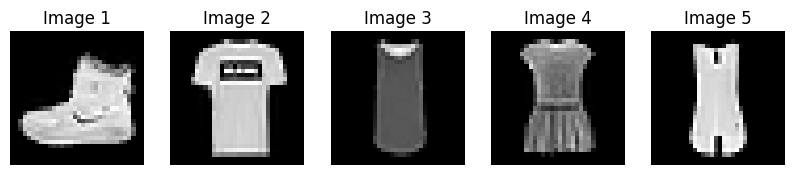

In [ ]:
# Affichage de quelques images d'entraînement
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')  # Afficher l'image en niveaux de gris
    plt.title("Image {}".format(i + 1))
    plt.axis('off')
plt.show()

# Étape 2 : Définition du modèle autoencodeur

## encoder

In [ ]:
# Définition de l'entrée de l'encodeur avec la taille de l'image et le nombre de canaux
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Couche de convolution 1 : 32 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)

# Couche de convolution 2 : 64 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Couche de convolution 3 : 128 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

# Sauvegarde de la forme avant l'aplatissage, nécessaire pour le décodeur
shape_before_flattening = K.int_shape(x)[1:]

# Aplatissement de la sortie des couches de convolution
x = layers.Flatten()(x)

# Couche dense pour la représentation compressée de dimension EMBEDDING_DIM
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

# Création du modèle de l'encodeur
encoder = models.Model(encoder_input, encoder_output)

# Affichage du résumé de l'encodeur
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

## Decodeur

In [ ]:
# Définition de l'entrée du décodeur avec la dimension de l'espace latent
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Couche dense pour préparer la sortie du décodeur
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

# Remise en forme de la sortie pour correspondre à la forme avant l'aplatissage
x = layers.Reshape(shape_before_flattening)(x)

# Couche de convolution transposée 1 : 128 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Couche de convolution transposée 2 : 64 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Couche de convolution transposée 3 : 32 filtres, taille du noyau 3x3, activation ReLU, même taille de sortie
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Couche de sortie avec le nombre de canaux (CHANNELS) et activation sigmoïde
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

# Création du modèle du décodeur
decoder = models.Model(decoder_input, decoder_output)

# Affichage du résumé du décodeur
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Autoencodeur
autoencodeur = models.Model(
    encoder_input, decoder(encoder_output)
)  # décodeur(encoder_output)
autoencodeur.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Étape 3 : Compilation du modèle
autoencodeur.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=".keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
# Étape 4 : Entraînement du modèle
autoencodeur.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3599 - val_loss: 0.2662
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2624 - val_loss: 0.2581
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.2561 - val_loss: 0.2561


In [ ]:
# Sauvegarde des modèles finaux
autoencodeur.save(".keras")  # Sauvegarde du modèle autoencodeur complet
encoder.save(".keras")  # Sauvegarde du modèle d'encodeur
decoder.save(".keras")  # Sauvegarde du modèle de décodeur

In [ ]:
# Étape 5 : Évaluation du modèle
# Calcul de l'erreur de reconstruction
loss = autoencodeur.evaluate(x_test, x_test)
print("Erreur de reconstruction sur l'ensemble de test : {:.4f}".format(loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2558
Erreur de reconstruction sur l'ensemble de test : 0.2561


In [ ]:
# Prediction des images
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
predictions = autoencodeur.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[7.39919983e-07],
         [1.64494836e-08],
         [3.02315826e-08],
         ...,
         [8.85863187e-08],
         [7.12157373e-08],
         [2.73980695e-05]],

        [[5.69834890e-09],
         [3.34262784e-10],
         [2.26315611e-09],
         ...,
         [1.55391930e-08],
         [2.38622366e-09],
         [1.48614015e-06]],

        [[4.96474222e-08],
         [1.14103624e-08],
         [4.00631762e-07],
         ...,
         [1.24523308e-06],
         [2.95534690e-08],
         [2.74701597e-06]],

        ...,

        [[1.50327983e-09],
         [7.34485112e-11],
         [4.94702839e-08],
         ...,
         [2.75501236e-07],
         [3.22430815e-09],
         [2.73883870e-07]],

        [[3.32144068e-09],
         [8.18388760e-11],
         [3.43409146e-09],
         ...,
         [7.87735488e-10],
         [3.79205944e-10],
         [6.54195048e-07]],

        [[3.88609033e-06],
         [8.24203141e-08],
         [8.89317334e-07],
         ...,
 

Exemples de vêtements réels
Reconstructions


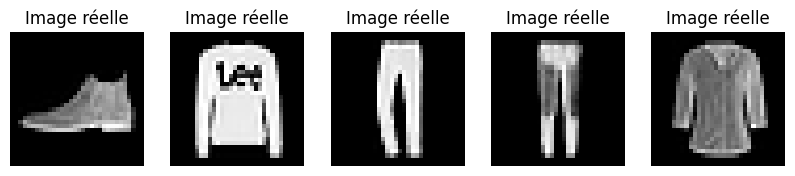

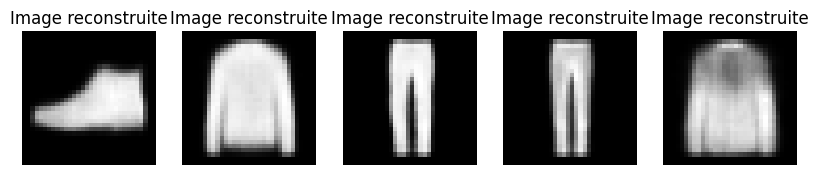

In [ ]:
# Affichage des vraies images
print("Exemples de vêtements réels")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example_images[i].reshape(32, 32), cmap='gray')
    plt.title("Image réelle")
    plt.axis('off')

# Affichage des images reconstruites
print("Reconstructions")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(predictions[i].reshape(32, 32), cmap='gray')
    plt.title("Image reconstruite")
    plt.axis('off')

plt.show()

# Embedding

In [ ]:
# Encodage des images
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Quelques exemples
print(embeddings[:10])

[[ -4.7596717   3.694693 ]
 [  0.6750135  -1.608002 ]
 [ -5.000836  -13.99062  ]
 [ -7.0670114 -11.269675 ]
 [ -1.0941665  -1.0693706]
 [ -2.6550267  -7.739864 ]
 [ -3.3995335  -2.6049192]
 [ -2.0692883  -1.7911732]
 [ -9.507972    1.0410172]
 [ -8.470666    2.8778045]]


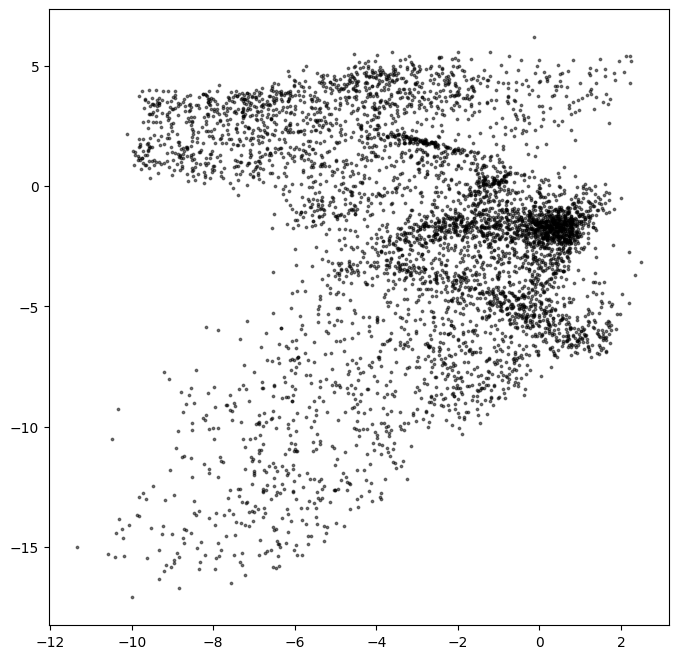

In [ ]:
# Afficher les points encodés dans un espace en 2D.
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

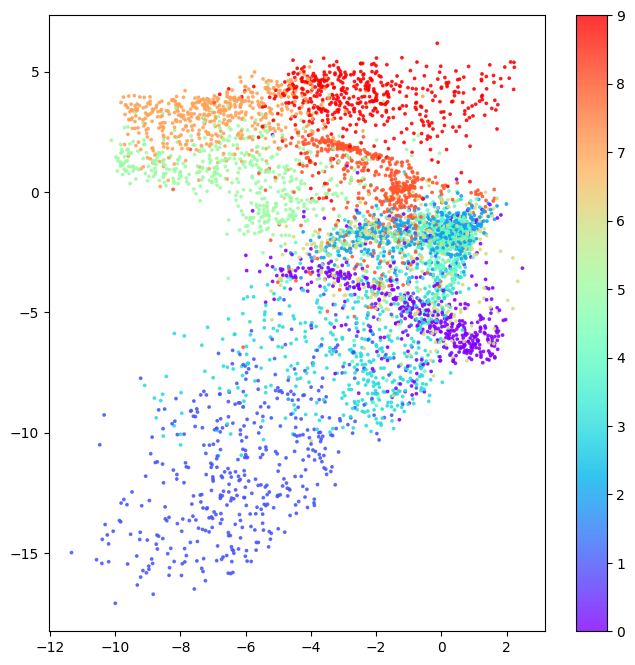

In [ ]:
# affichage en fonction du type
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [ ]:
# Obtenir la plage des valeurs existantes
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Échantillonner quelques points dans l'espace latent
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# Décoder les points échantillonnés
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


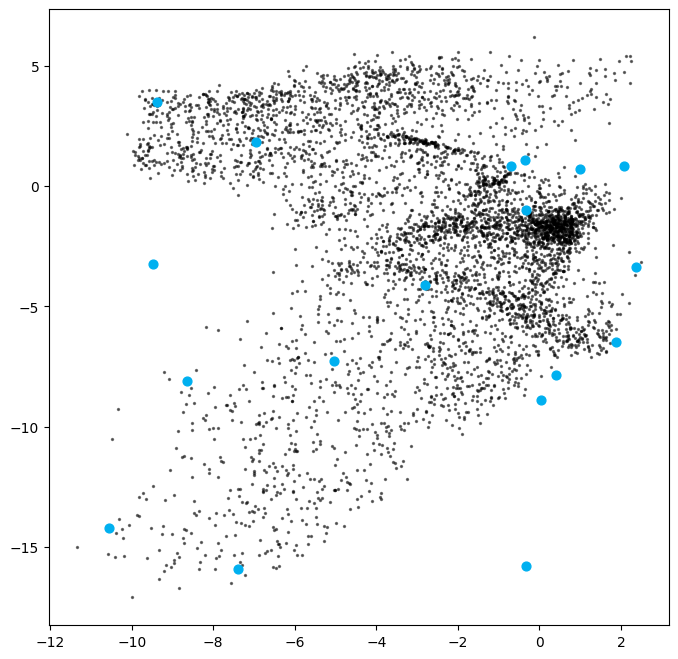

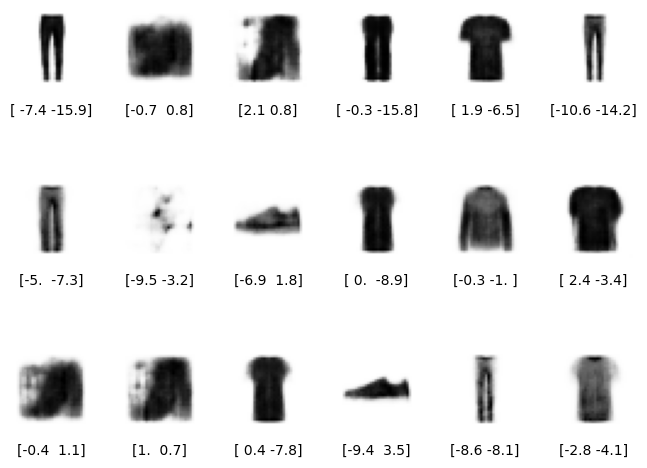

In [ ]:
# Dessiner un graphique...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... des embeddings originaux ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... et des nouveaux points générés dans l'espace latent
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Ajouter en dessous une grille des images décodées
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


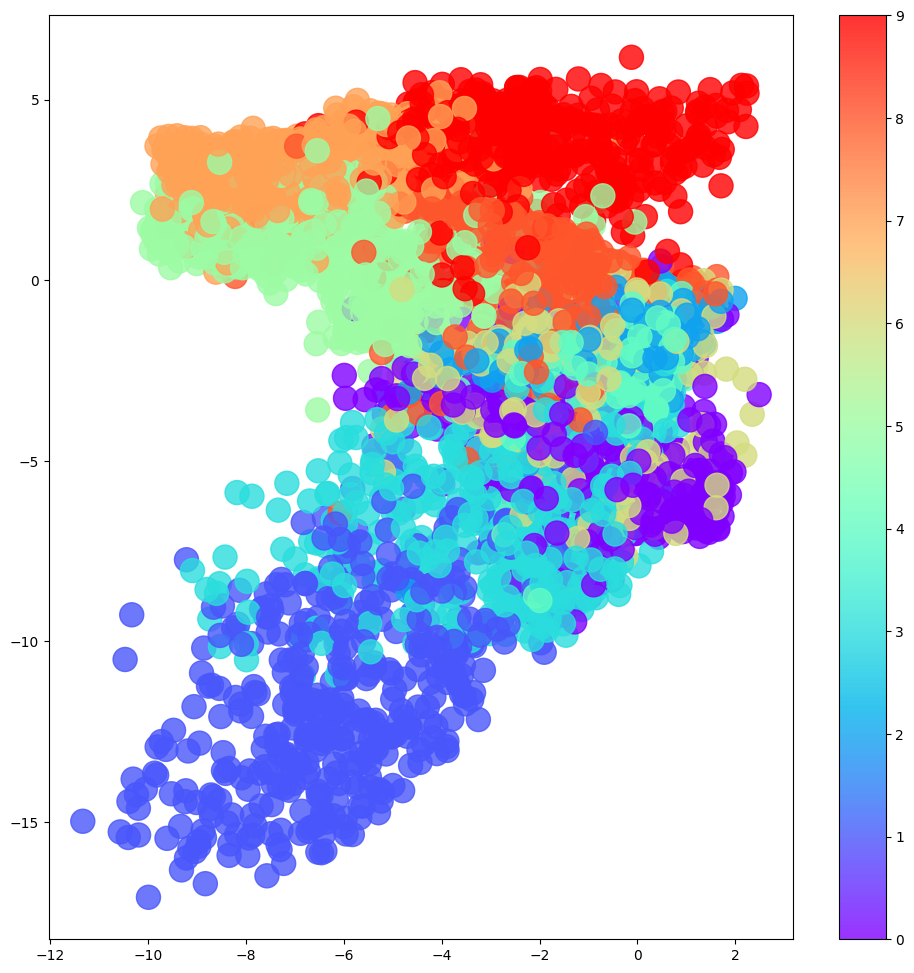

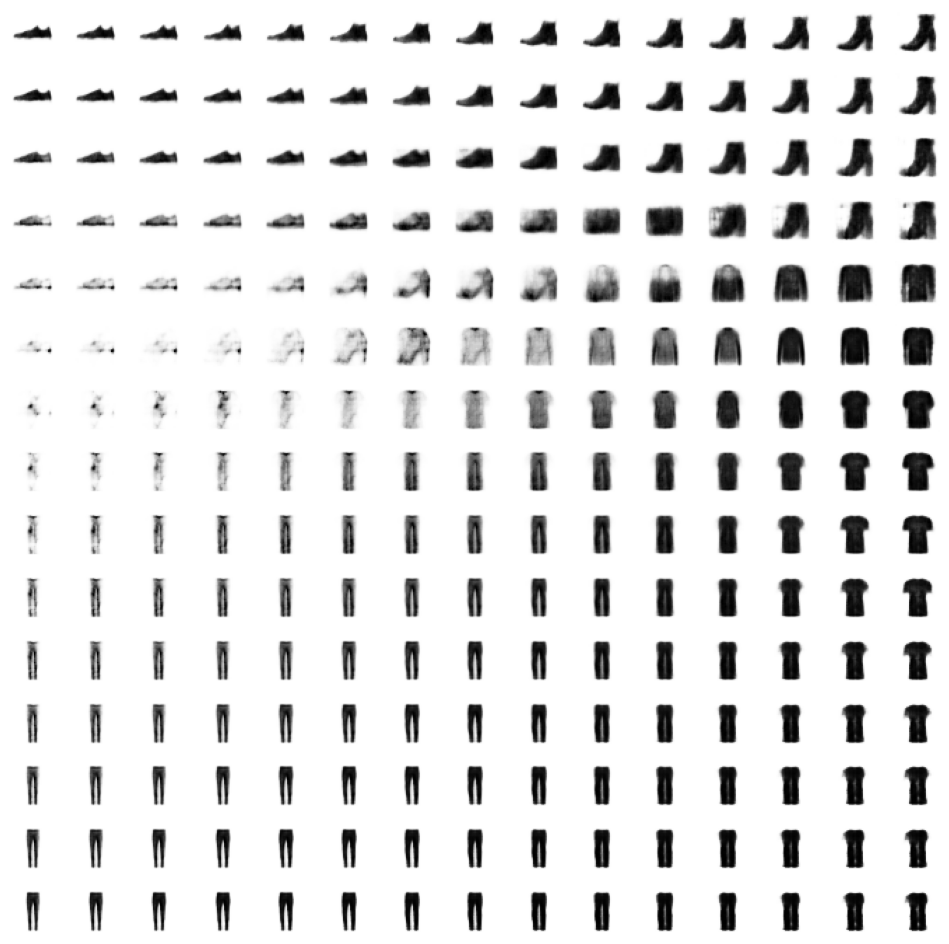

In [ ]:
# Colorer les embeddings en fonction de leur label (type de vêtement - voir la table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")